In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


from scipy import stats
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_validate, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer,make_column_selector
from sklearn.metrics import f1_score,classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor,plot_tree
from sklearn import metrics

from xgboost import XGBClassifier, plot_tree
import xgboost as xgb

from statsmodels.formula.api import ols
from statsmodels.api import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

import pickle


### Importation CSV et création du dataframe

In [2]:
df = pd.read_csv("data.csv")
df.NewExist = df.NewExist.astype(str)
df.UrbanRural= df.UrbanRural.astype(str)
df.Real_estate = df.Real_estate.astype(str)
df

State BankState                           Industry  Term    GrAppv  \
0         IN        OH                       Retail trade    84   60000.0   
1         IN        IN    Accommodation and food services    60   40000.0   
2         IN        IN  Health care and social assistance   180  287000.0   
3         OK        OK                             Others    60   35000.0   
4         FL        FL                             Others   240  229000.0   
...      ...       ...                                ...   ...       ...   
893285    OH        IL                       Retail trade    60   70000.0   
893286    OH        IL                       Retail trade    60   85000.0   
893287    CA        CA                      Manufacturing   108  300000.0   
893288    HI        HI                             Others    60   75000.0   
893289    HI        HI                             Others    48   30000.0   

        MIS_Status  NoEmp NewExist  CreateJob  RetainedJob  FranchiseCode  \
0                0      4        1          0            0              1   
1                0      2        1          0            0              1   
2                0      7        0          0            0              1   
3                0      2        0          0            0              1   
4                0     14        0          7            7              1   
...            ...    ...      ...        ...          ...            ...   
893285           0      6        0          0            0              1   
893286           0      6        0          0            0              1   
893287           0     26        0          0            0              1   
893288           1      6        0          0            0              1   
893289           0      1        1          0            0              1   

       UrbanRural Real_estate  
0               0           0  
1               0           0  
2               0           0  
3               0           0  
4               0           1  
...           ...         ...  
893285          0           0  
893286          0           0  
893287          0           0  
893288          0           0  
893289          0           0  

[893290 rows x 13 columns]

In [3]:
df.columns

Index(['State', 'BankState', 'Industry', 'Term', 'GrAppv', 'MIS_Status',
       'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode',
       'UrbanRural', 'Real_estate'],
      dtype='object')

In [4]:
df.FranchiseCode = df.FranchiseCode.apply(lambda x: 1 if x ==1 else 0)
df.FranchiseCode = df.FranchiseCode.astype(str)
df.FranchiseCode.value_counts()


1    841756
0     51534
Name: FranchiseCode, dtype: int64

### Création de la matrice X (variables explicatives) et de la série y (variable cible)

In [6]:
X = df.drop(['MIS_Status'], axis=1)
y = df['MIS_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, train_size=0.9, random_state=42, stratify=y)

# Score du dummy classifier
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)



0.8246817942661397

### Création d'un pipeline

In [5]:
transformer = make_column_transformer(
    (OneHotEncoder(),make_column_selector(dtype_exclude=np.number)),
    (StandardScaler(),make_column_selector(dtype_include=np.number))
    )

### Création d'un  RandomForest

In [7]:
forest= make_pipeline(
    transformer,
    RandomForestClassifier(
        max_depth=5,
        n_estimators=100,
        min_samples_leaf=1000,
        class_weight='balanced'
    )
)

# Entrainement de notre modèle en utilisant les paramètres par défaut 
forest.fit(X_train,y_train)

#Utilisation d'un .features_importances_ pour déterminer quelle variable est importante pour la prédiction
A=forest.named_steps['randomforestclassifier'].feature_importances_

# #Score de notre modèle après la cross_validation
cross_val=cross_validate(forest, X_train, y_train,scoring='f1',cv=5)

cross_val['test_score'].mean()

KeyboardInterrupt: 

In [ ]:
# y_pred=forest.predict(X_train)
# f1_score(y_train,y_pred)

In [ ]:
A_columns=transformer.get_feature_names_out()
A_columns

array(['onehotencoder__State_AK', 'onehotencoder__State_AL',
       'onehotencoder__State_AR', 'onehotencoder__State_AZ',
       'onehotencoder__State_CA', 'onehotencoder__State_CO',
       'onehotencoder__State_CT', 'onehotencoder__State_DC',
       'onehotencoder__State_DE', 'onehotencoder__State_FL',
       'onehotencoder__State_GA', 'onehotencoder__State_HI',
       'onehotencoder__State_IA', 'onehotencoder__State_ID',
       'onehotencoder__State_IL', 'onehotencoder__State_IN',
       'onehotencoder__State_KS', 'onehotencoder__State_KY',
       'onehotencoder__State_LA', 'onehotencoder__State_MA',
       'onehotencoder__State_MD', 'onehotencoder__State_ME',
       'onehotencoder__State_MI', 'onehotencoder__State_MN',
       'onehotencoder__State_MO', 'onehotencoder__State_MS',
       'onehotencoder__State_MT', 'onehotencoder__State_NC',
       'onehotencoder__State_ND', 'onehotencoder__State_NE',
       'onehotencoder__State_NH', 'onehotencoder__State_NJ',
       'onehotencoder__S

In [ ]:
df_coeff = pd.DataFrame([A_columns,A], index=['features', 'coeff']).T.explode('coeff')
df_coeff.sort_values(by='coeff', ascending=False).head(20)

features     coeff
79                               standardscaler__Term  0.384352
78                       onehotencoder__Real_estate_1  0.109086
76                        onehotencoder__UrbanRural_1  0.105152
83                        standardscaler__RetainedJob  0.095945
77                       onehotencoder__Real_estate_0  0.080513
80                             standardscaler__GrAppv  0.065313
75                        onehotencoder__UrbanRural_0  0.046979
64                     onehotencoder__Industry_Others  0.040376
82                          standardscaler__CreateJob  0.019554
81                              standardscaler__NoEmp  0.018172
58  onehotencoder__Industry_Health care and social...  0.005323
67               onehotencoder__Industry_Retail trade  0.004121
9                             onehotencoder__State_FL  0.003322
51  onehotencoder__Industry_Accommodation and food...  0.003234
4                             onehotencoder__State_CA  0.002141
72                          onehotencoder__NewExist_1  0.001675
74                     onehotencoder__FranchiseCode_1  0.001514
10                            onehotencoder__State_GA  0.001438
55               onehotencoder__Industry_Construction  0.001343
26                            onehotencoder__State_MT  0.001195

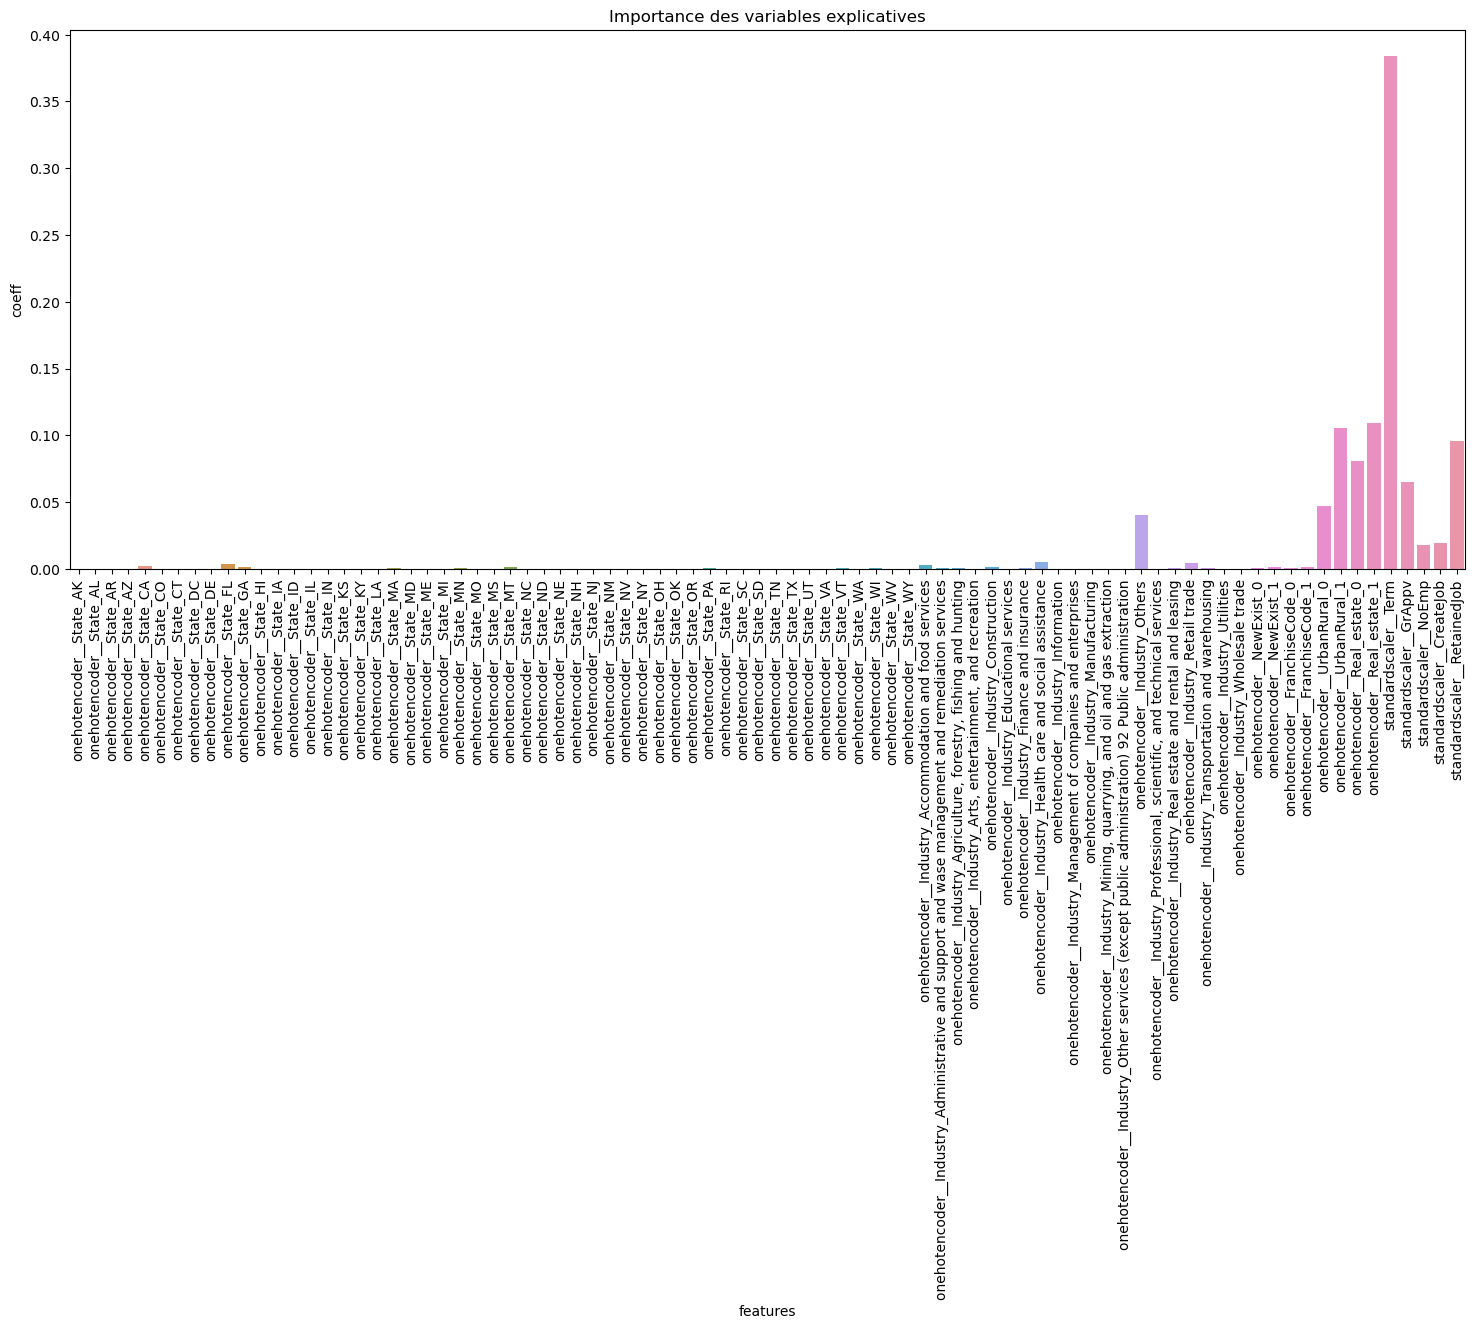

In [ ]:
# plt.figure(figsize=[18,7])
# sns.barplot(data=df_coeff,x='features',y='coeff')
# plt.xticks(rotation=90)
# plt.title("Importance des variables explicatives")
# plt.show()

In [7]:
X = df[['UrbanRural','CreateJob','RetainedJob','NoEmp','Real_estate','GrAppv','Industry','Term','FranchiseCode','NewExist','State']]
y = df['MIS_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, train_size=0.9, random_state=42, stratify=y)

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893290 entries, 0 to 893289
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   UrbanRural   893290 non-null  object 
 1   CreateJob    893290 non-null  int64  
 2   NoEmp        893290 non-null  int64  
 3   Real_estate  893290 non-null  object 
 4   GrAppv       893290 non-null  float64
 5   Industry     893290 non-null  object 
 6   Term         893290 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 47.7+ MB


In [ ]:
forest= make_pipeline(
    transformer,
    RandomForestClassifier(
        max_depth=10,
        n_estimators=100,
        min_samples_leaf=6000,
        min_samples_split=20000,
        max_leaf_nodes=15,
        class_weight='balanced'
    )
)

# Entrainement de notre modèle en utilisant les paramètres par défaut 
forest.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6ff815b8b0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6ff815bb20>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        max_leaf_nodes=15,
                                        min_samples_leaf=6000,
                                        min_samples_split=20000))])

In [ ]:
# y_pred=cross_val_predict(forest,X_train, y_train)

NameError: name 'forest' is not defined

In [ ]:
y_pred=cross_val_predict(forest,X_train, y_train)

In [ ]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.78      0.86    664423
           1       0.44      0.82      0.58    141041

    accuracy                           0.79    805464
   macro avg       0.70      0.80      0.72    805464
weighted avg       0.86      0.79      0.81    805464



In [ ]:
cross_val=cross_validate(forest, X_train, y_train,scoring='f1_macro',cv=5)

cross_val['test_score'].mean()

KeyboardInterrupt: 

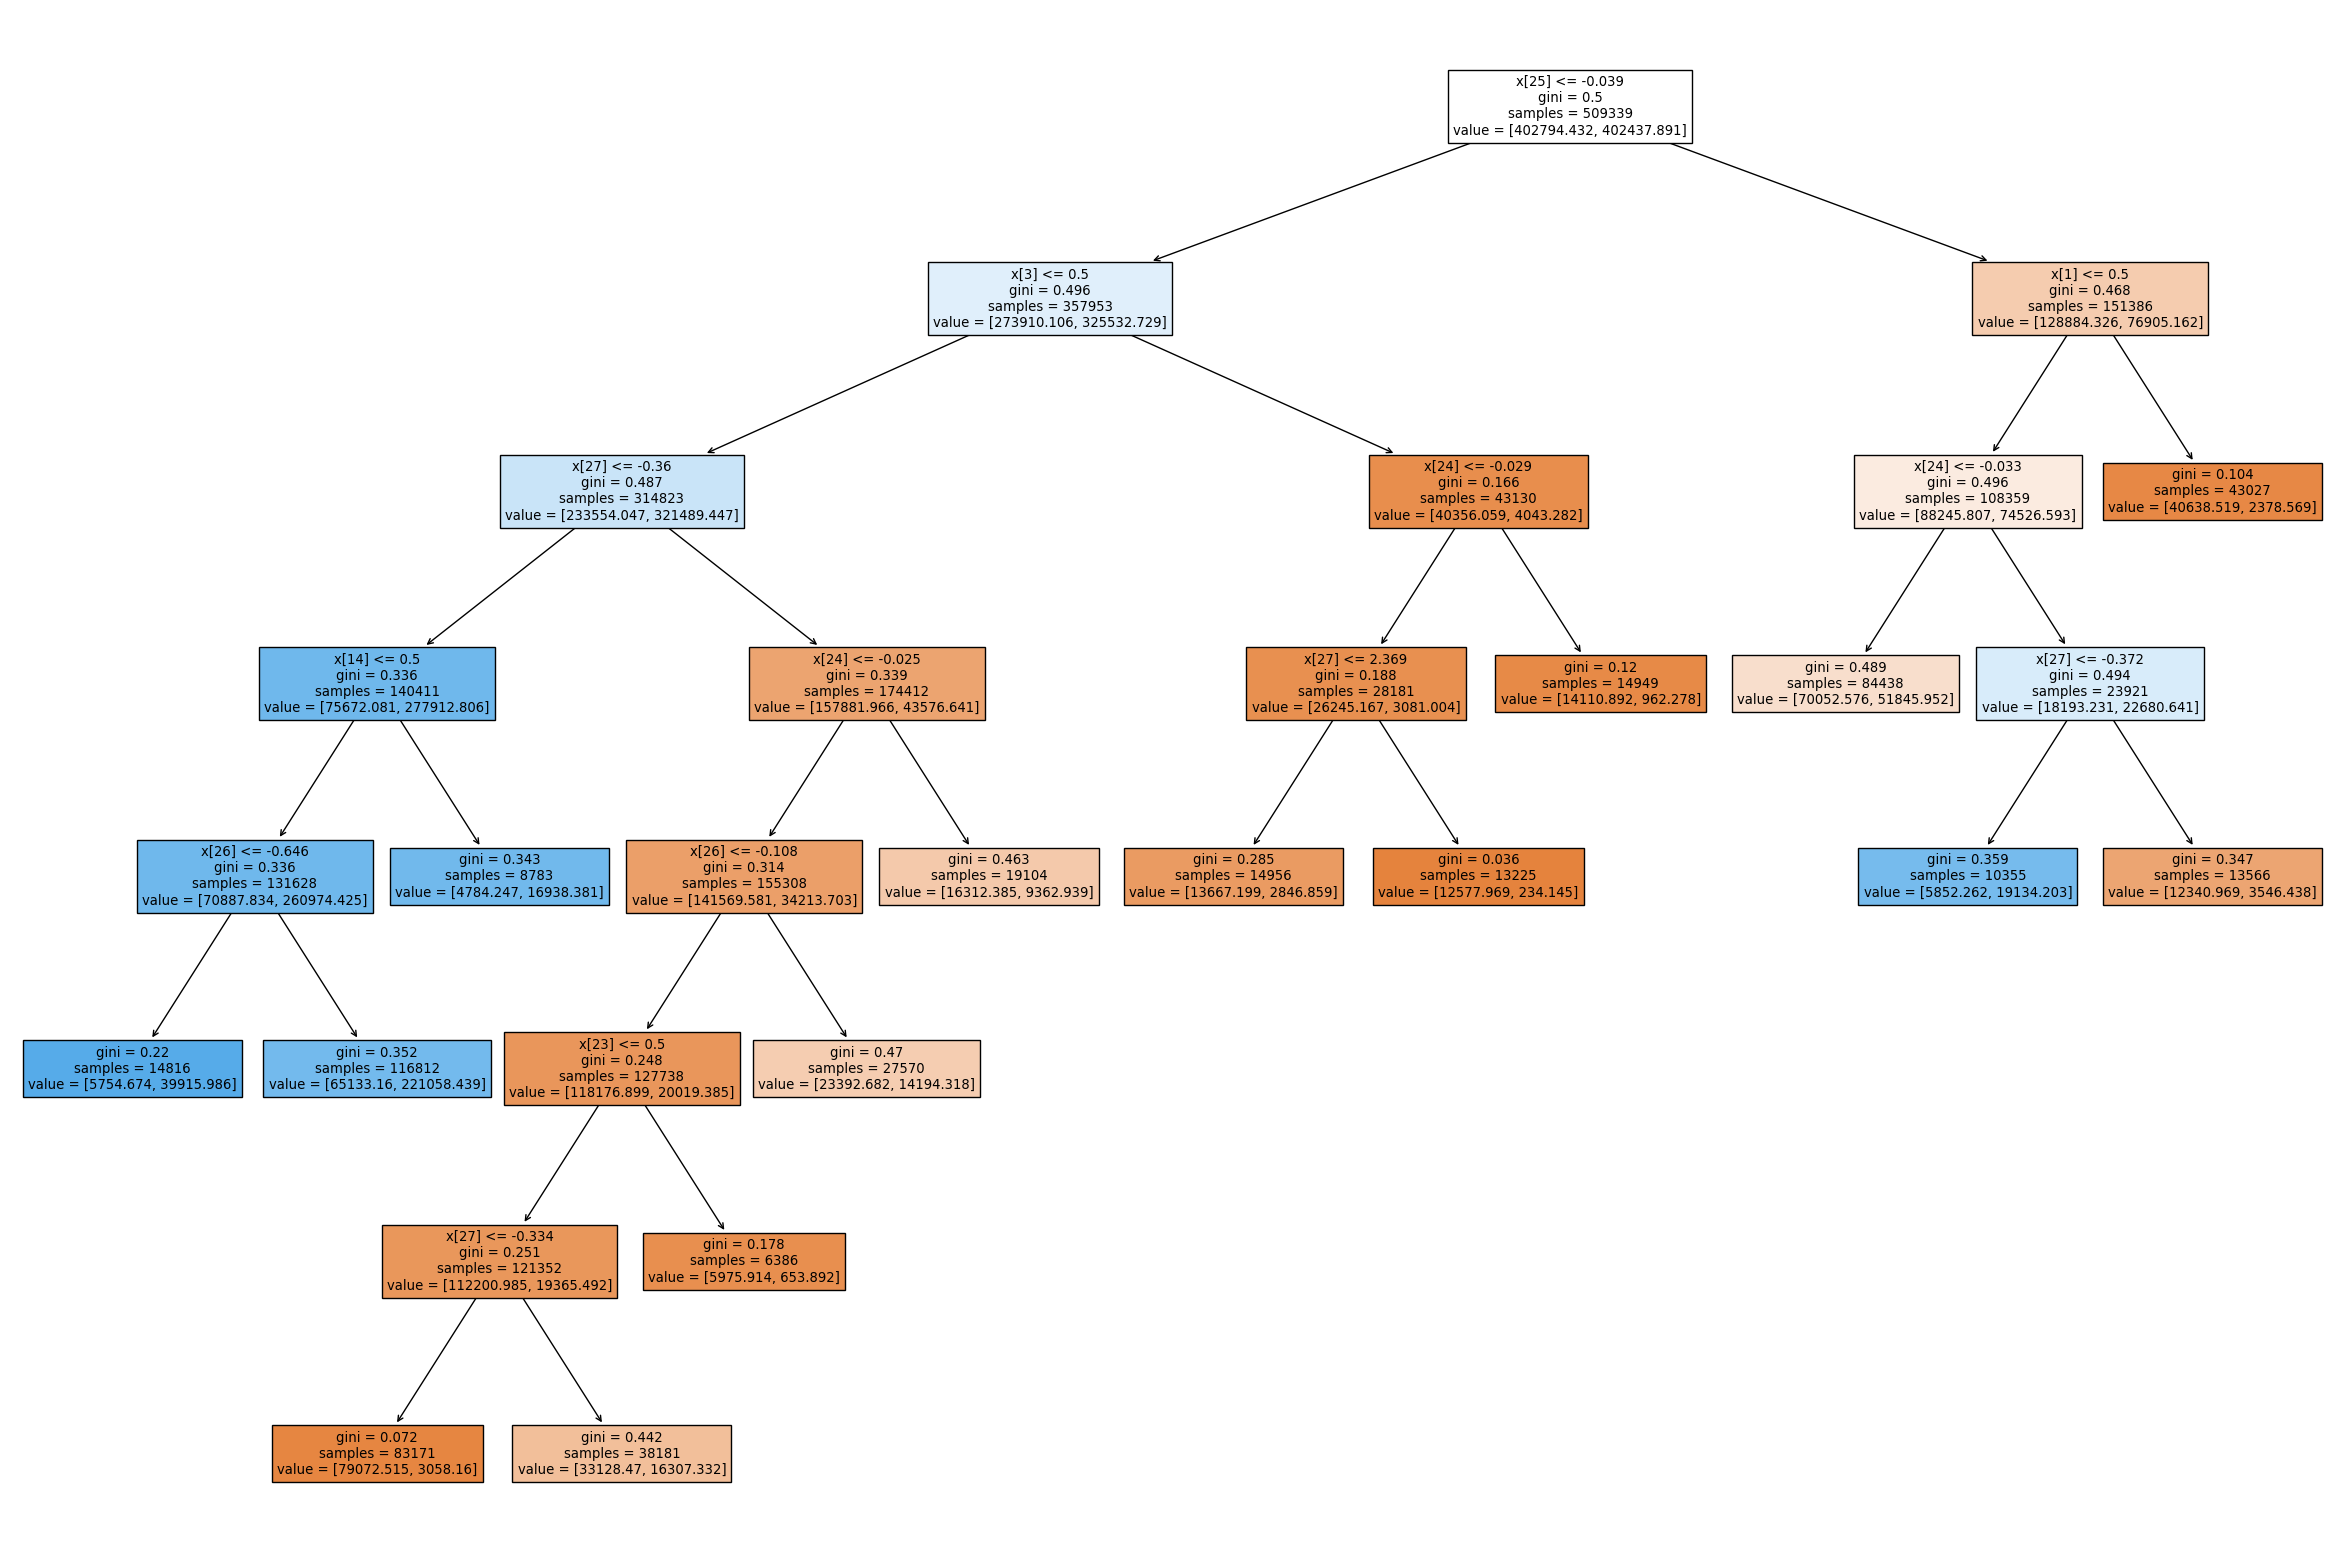

In [ ]:
fig = plt.figure(figsize=(30,20))
plot_tree(forest.named_steps['randomforestclassifier'].estimators_[0],filled=True)
plt.show()

In [8]:
xgb= make_pipeline(
        transformer,
        XGBClassifier(
            max_depth=10,
            learning_rate=0.1,
            n_estimators=100,
            gamma=50, 
            min_child_weight=0,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.005
    )
)

# Entrainement de notre modèle en utilisant les paramètres par défaut 
xgb.fit(X_train,y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe048397640>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe048397940>)])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None...
                               feature_types=None, gamma=50, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=0, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

UrbanRural  CreateJob  RetainedJob  NoEmp Real_estate    GrAppv  \
19306           1          0            9      9           0   50000.0   
858752          0          6            0     14           1  196000.0   
593031          1          0            0     20           0   80000.0   
156475          1          5            3      8           0   25000.0   
507164          0          0            0      3           0   30000.0   
...           ...        ...          ...    ...         ...       ...   
184475          1          0            2      2           0  105000.0   
333526          0          0            0     27           0  510000.0   
578112          0          0            0     21           0  175000.0   
235087          1          4           10      6           0  108600.0   
508120          2          4            8      8           0  680000.0   

                                                 Industry  Term FranchiseCode  \
19306                                       Manufacturing    84             1   
858752                                      Manufacturing   240             1   
593031                    Accommodation and food services   120             0   
156475  Administrative and support and wase management...    83             1   
507164                  Health care and social assistance    60             1   
...                                                   ...   ...           ...   
184475                    Accommodation and food services   120             1   
333526                                             Others   120             1   
578112                                    Wholesale trade    16             1   
235087                    Accommodation and food services    74             0   
508120                                      Manufacturing   120             1   

       NewExist State  
19306         0    CA  
858752        0    FL  
593031        1    CA  
156475        0    PA  
507164        0    IL  
...         ...   ...  
184475        0    CA  
333526        0    OK  
578112        0    CA  
235087        0    CA  
508120        0    MA  

[803961 rows x 11 columns]

In [14]:
cross_val=cross_validate(xgb, X_train, y_train,scoring='f1_macro',cv=5)

cross_val['test_score'].mean()

KeyboardInterrupt: 

In [ ]:
test= np.array([0,0,4,0,60000.0,'Retail trade',84])
B=dict(zip(X.columns,test))
B


{'UrbanRural': '0',
 'CreateJob': '0',
 'NoEmp': '4',
 'Real_estate': '0',
 'GrAppv': '60000.0',
 'Industry': 'Retail trade',
 'Term': '84'}

In [ ]:
A= pd.DataFrame( B, index=[0])
A

UrbanRural CreateJob NoEmp Real_estate   GrAppv      Industry Term
0          0         0     4           0  60000.0  Retail trade   84

In [ ]:
xgb.predict(A)[0]

0

In [ ]:
f1_score(y_train,y_pred, average='macro')

0.8760262104134251

In [16]:
# y_pred=xgb.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96    663015
           1       0.84      0.77      0.80    140946

    accuracy                           0.93    803961
   macro avg       0.89      0.87      0.88    803961
weighted avg       0.93      0.93      0.93    803961



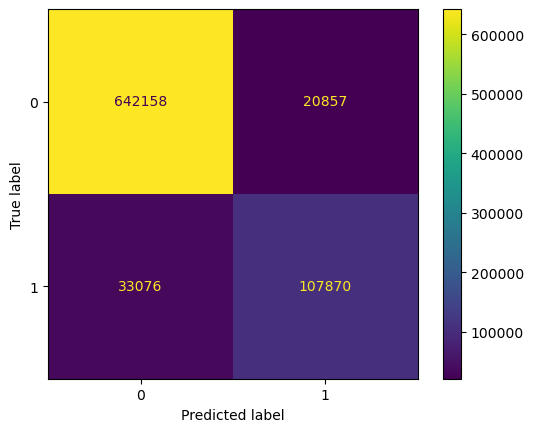

In [17]:
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# fig = plt.figure(figsize=(30,20))
# plot_tree(forest.named_steps['classifier'].estimators_[0],filled=True)
# plt.show()

AttributeError: module 'xgboost' has no attribute 'named_steps'

<Figure size 4000x2000 with 0 Axes>

In [ ]:
# lo_reg = make_pipeline(
#     transformer,
#     LogisticRegression(
#         penalty='l2',
#         solver='saga',
#         class_weight='balanced',
#         multi_class='ovr'
#         )
#     )

# # Entrainement de notre modèle en utilisant les paramètres par défaut 
# lo_reg.fit(X_train,y_train)

# # Score de notre modèle après la cross_validation
# cross_val=cross_validate(lo_reg, X_train, y_train,scoring='f1',cv=5)
# cross_val['test_score'].mean()

### Utilisation d'un RandomSearch pour obtenir une idée de l'ordre de grandeur des paramètres

In [ ]:
#Pour trouver le nom des paramètres590599
forest.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fdc40e5e340>),
                                   ('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fdc40e5e3a0>)])),
  ('randomforestclassifier',
   RandomForestClassifier(class_weight='balanced', max_depth=10,
                          min_samples_leaf=2500, min_samples_split=2500))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdc40e5e340>),
                                 ('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector o

In [ ]:
# param_rand = {'randomforestclassifier__min_samples_leaf':np.arange(1000,10000,100),
#               'randomforestclassifier__max_depth':np.arange(5,10,1),
#               'randomforestclassifier__min_samples_split':np.arange(1000,10000,100)
#                 }
                
# random_search = RandomizedSearchCV(forest, param_distributions=param_rand,scoring='f1', n_iter=1, cv=5, random_state=42)

# random_search.fit(X_train, y_train)
# print(random_search.best_params_)

{'randomforestclassifier__min_samples_split': 5500, 'randomforestclassifier__min_samples_leaf': 9500, 'randomforestclassifier__max_depth': 6}


In [ ]:
# random_search.best_estimator_
# random_search.best_score_

0.5630030033788367

### Utilisation d'un GridSearch pour cibler les meilleurs paramètres

In [ ]:
# params = {'randomforestclassifier__min_samples_leaf':np.arange(2150,2300,1),
#           'randomforestclassifier__max_depth':[6]
#             }

# grid=GridSearchCV(forest, param_grid=params, scoring='f1', cv=5)
# grid.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# grid.best_score_

0.37606272607064106

In [9]:
with open('xgb.pkl', 'wb') as file:
  pickle.dump(xgb, file)


In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 803961 entries, 19306 to 508120
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   UrbanRural     803961 non-null  object 
 1   CreateJob      803961 non-null  int64  
 2   RetainedJob    803961 non-null  int64  
 3   NoEmp          803961 non-null  int64  
 4   Real_estate    803961 non-null  object 
 5   GrAppv         803961 non-null  float64
 6   Industry       803961 non-null  object 
 7   Term           803961 non-null  int64  
 8   FranchiseCode  803961 non-null  object 
 9   NewExist       803961 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 67.5+ MB
